In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import multinomial, norm, binom, laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Assume the true model is $P_*$ whose mean is the target. Assume the first two raw moments are finite and given by $\mu$ and $\sigma^2$. However, we work with a simple model, say $N(\theta, 1)$. Then we study the performance of the estimator of this model (for mean) under model collapse framework.

At step $t$, we observe $X_1^{(t)},\dots,X_{m_t}^{(t)} \sim \alpha_t P_* + (1-\alpha_t) N(\hat{\theta}_{t-1}, 1)$ iid (the second component is the latest working model). Based on this, we estimate $\hat{\theta}_t$ as the sample mean (of this current observations). What can be said about (i) $E(\hat{\theta}_t$ and (ii) $\text{Var})(\hat{\theta}_t)$ as $t$ grows. 

In [3]:
def generate_mixture(alpha, laplace_params, normal_mu, n):
    m = binom.rvs(n=n, p=alpha)
    Y = norm.rvs(loc=normal_mu, scale=1, size=n-m) # working model
    loc, scale = laplace_params
    X = laplace.rvs(loc=loc, scale=scale, size=m) # true model
    D = np.append(X, Y)
    return D

def generate_mixture2(alpha, normal_params, normal_mu, n):
    m = binom.rvs(n=n, p=alpha)
    Y = norm.rvs(loc=normal_mu, scale=1, size=n-m) # working model
    loc, scale = normal_params
    X = norm.rvs(loc=loc, scale=scale, size=m) # true model
    D = np.append(X, Y)
    return D

def estimate(D):
    mu_hat = D.mean()
    return mu_hat

def distance(theta1, theta2):
    return np.linalg.norm(theta1 - theta2)**2

In [4]:
X = generate_mixture(0.3, (10, 1.3), 1.2, 1000)
Y = generate_mixture2(0.3, (10, 1.3), 1.2, 1000)

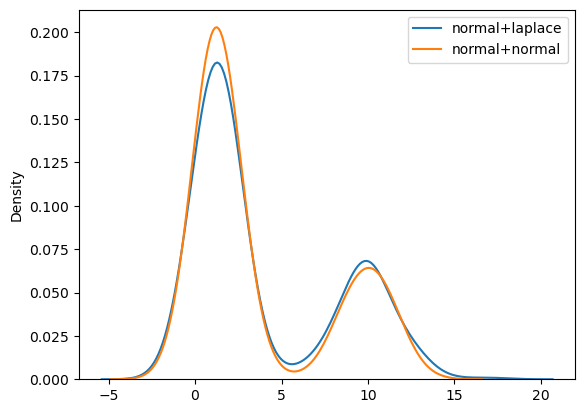

In [5]:
sns.kdeplot(X, label='normal+laplace')
sns.kdeplot(Y, label='normal+normal')
plt.legend()
plt.show()

## Case 1: Fixed sequence $\alpha, m$

Use true model $N(\theta_*, 1)$ (correctly specified) as one case and $\text{Lap}(\theta_*, 2)$ (mis-specified) as another. The working model is $N(\theta, 1)$.

In [38]:
# Exp1: correctly specified 

theta0 = 4.5
n = 40
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
rep = 100
T = 400

Theta_hat = np.zeros((len(alphas), rep, T))
np.random.seed(10)

for i, alpha in enumerate(alphas):
    for j in tqdm(range(rep)):
        X = norm.rvs(loc=theta0, scale=1., size=n) # true model
        mu_hat = estimate(X)
        Theta_hat[i,j,0] = mu_hat
        
        for t in range(T-1):
            X = generate_mixture2(alpha, (theta0, 1.), mu_hat, n) # mix true model + working model
            mu_hat = estimate(X)
            Theta_hat[i,j,t+1] = mu_hat

100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


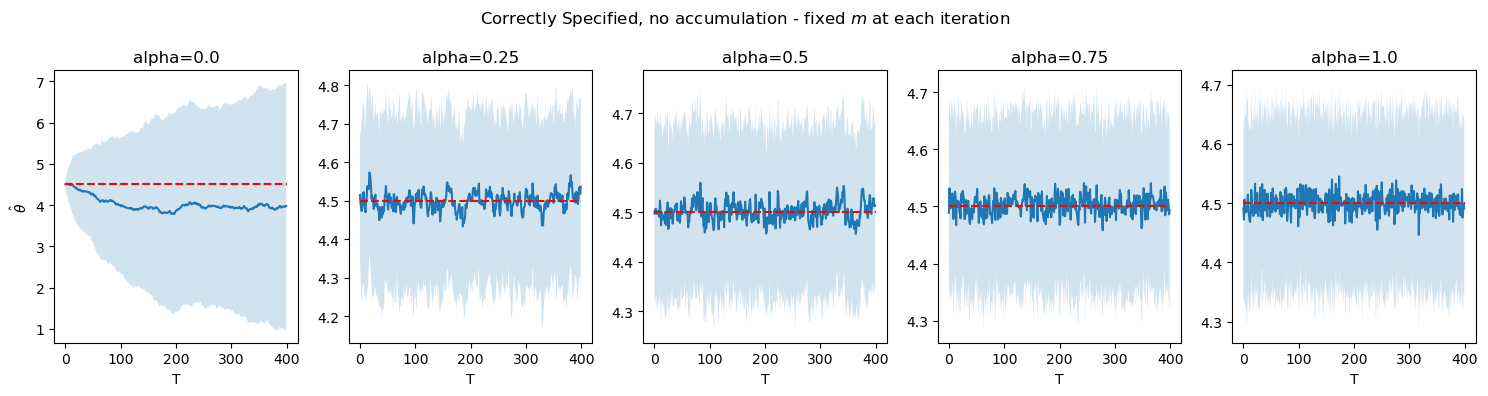

In [48]:
# Theta_hat -> (alpha=3, rep=500, T=1000)

Theta_mean = Theta_hat.mean(axis=1)
Theta_sd = Theta_hat.std(axis=1)

fig, ax = plt.subplots(figsize=(15, 4), ncols=5)

for i in range(len(alphas)):
    ax[i].plot(range(T), Theta_mean[i], label=alphas[i])
    ax[i].fill_between(range(T), Theta_mean[i] - Theta_sd[i], Theta_mean[i]+Theta_sd[i], alpha=0.2)
    ax[i].hlines(y=theta0, xmin=0, xmax=T, linestyle='dashed', color='red')
    ax[i].set_title(f'alpha={alphas[i]}')
    ax[i].set_xlabel('T')
ax[0].set_ylabel('$\hat{\\theta}$')
plt.suptitle('Correctly Specified, no accumulation - fixed $m=40$ at each iteration')
plt.tight_layout()
plt.show()

In [11]:
# Exp2: misspecified specified 

theta0 = 4.5
n = 40
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
rep = 100
T = 400

Theta_hat = np.zeros((len(alphas), rep, T))
np.random.seed(10)

for i, alpha in enumerate(alphas):
    for j in tqdm(range(rep)):
        X = laplace.rvs(loc=theta0, scale=2., size=n) # true model
        mu_hat = estimate(X)
        Theta_hat[i,j,0] = mu_hat
        
        for t in range(T-1):
            X = generate_mixture(alpha, (theta0, 2.0), mu_hat, n) # mix true model + working model
            mu_hat = estimate(X)
            Theta_hat[i,j,t+1] = mu_hat

100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


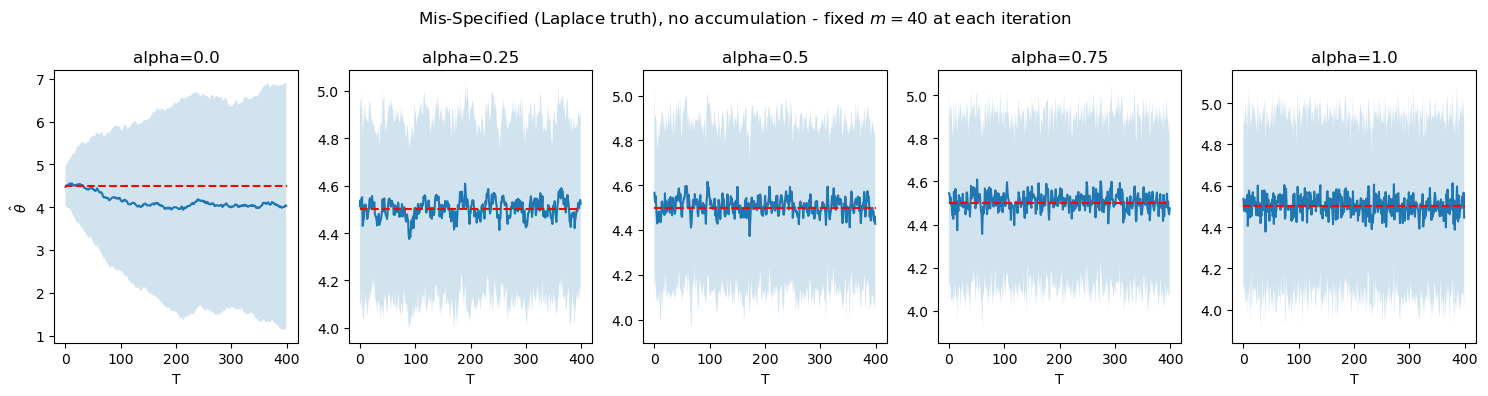

In [12]:
# Theta_hat -> (alpha=3, rep=500, T=1000)

Theta_mean = Theta_hat.mean(axis=1)
Theta_sd = Theta_hat.std(axis=1)

fig, ax = plt.subplots(figsize=(15, 4), ncols=5)

for i in range(len(alphas)):
    ax[i].plot(range(T), Theta_mean[i], label=alphas[i])
    ax[i].fill_between(range(T), Theta_mean[i] - Theta_sd[i], Theta_mean[i]+Theta_sd[i], alpha=0.2)
    ax[i].hlines(y=theta0, xmin=0, xmax=T, linestyle='dashed', color='red')
    ax[i].set_title(f'alpha={alphas[i]}')
    ax[i].set_xlabel('T')
ax[0].set_ylabel('$\hat{\\theta}$')
plt.suptitle('Mis-Specified (Laplace truth), no accumulation - fixed $m=40$ at each iteration')
plt.tight_layout()
plt.savefig('plots/fixed_m_fixed_alpha.pdf')
plt.show()

In [24]:
# Exp3: misspecified specified + accumulation

theta0 = 4.5
n = 40
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
rep = 100
T = 400

Theta_hat = np.zeros((len(alphas), rep, T))
np.random.seed(10)

for i, alpha in enumerate(alphas):
    for j in tqdm(range(rep)):
        X = laplace.rvs(loc=theta0, scale=2., size=n) # true model
        mu_hat = estimate(X)
        Theta_hat[i,j,0] = mu_hat
        
        for t in range(T-1):
            Y = generate_mixture(alpha, (theta0, 2.0), mu_hat, n) # mix true model + working model
            X = np.append(X, Y)
            mu_hat = estimate(X)
            Theta_hat[i,j,t+1] = mu_hat

100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


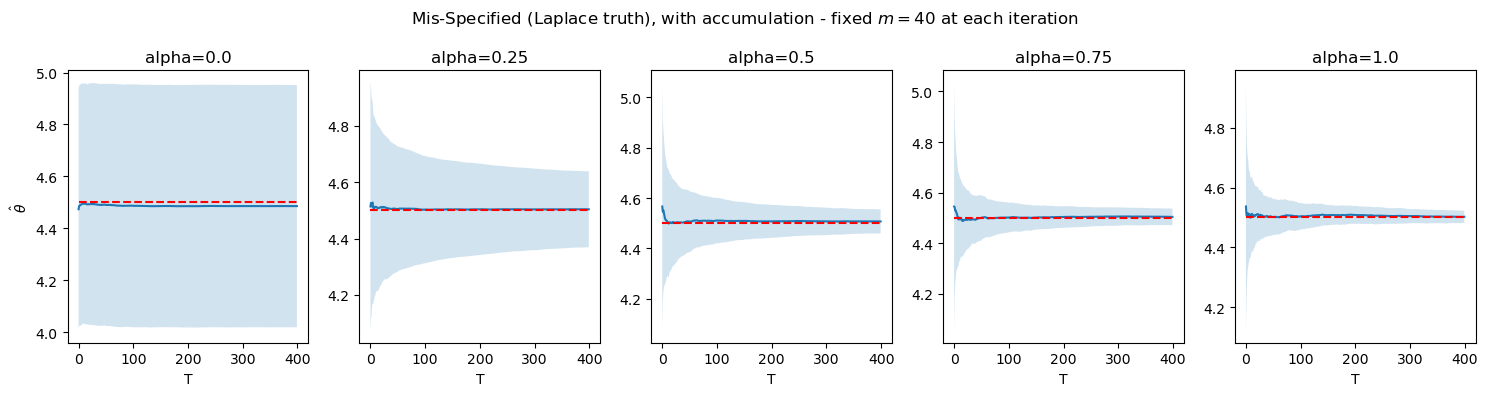

In [25]:
# Theta_hat -> (alpha=3, rep=500, T=1000)

Theta_mean = Theta_hat.mean(axis=1)
Theta_sd = Theta_hat.std(axis=1)

fig, ax = plt.subplots(figsize=(15, 4), ncols=5)

for i in range(len(alphas)):
    ax[i].plot(range(T), Theta_mean[i], label=alphas[i])
    ax[i].fill_between(range(T), Theta_mean[i] - Theta_sd[i], Theta_mean[i]+Theta_sd[i], alpha=0.2)
    ax[i].hlines(y=theta0, xmin=0, xmax=T, linestyle='dashed', color='red')
    ax[i].set_title(f'alpha={alphas[i]}')
    ax[i].set_xlabel('T')
ax[0].set_ylabel('$\hat{\\theta}$')
plt.suptitle('Mis-Specified (Laplace truth), with accumulation - fixed $m=40$ at each iteration')
plt.tight_layout()
plt.savefig('plots/accu_fixed_m_fixed_alpha.pdf')
plt.show()

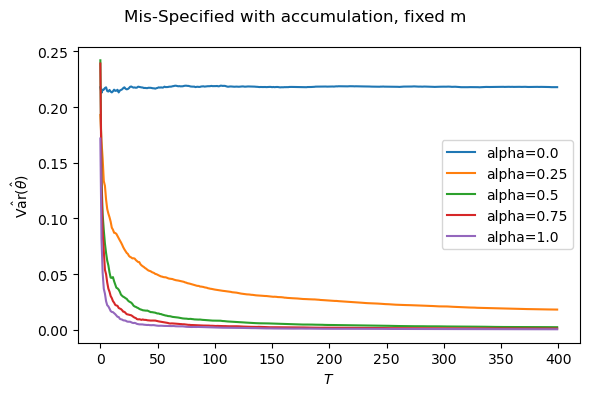

In [26]:
Theta_var = Theta_hat.var(axis=1)

fig, ax = plt.subplots(figsize=(6, 4))

for i in range(len(alphas)):
    ax.plot(range(T), Theta_var[i], label=f'alpha={alphas[i]}')
ax.set_ylabel('$\hat{\\text{Var}}(\hat{\\theta})$')
ax.set_xlabel('$T$')
plt.legend()
plt.suptitle('Mis-Specified with accumulation, fixed m')
plt.tight_layout()
plt.savefig('plots/accu_fixed_m_fixed_alpha_var.pdf')
plt.show()

In [27]:
# Exp4: misspecified + no accumulation + increasing n (linearly)

theta0 = 4.5
n = 40
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
rep = 100
T = 400

Theta_hat = np.zeros((len(alphas), rep, T))
np.random.seed(10)

for i, alpha in enumerate(alphas):
    for j in tqdm(range(rep)):
        X = laplace.rvs(loc=theta0, scale=2., size=n) # true model
        mu_hat = estimate(X)
        Theta_hat[i,j,0] = mu_hat
        
        for t in range(T-1):
            X = generate_mixture(alpha, (theta0, 2.0), mu_hat, n*(t+2)) # mix true model + working model
            mu_hat = estimate(X)
            Theta_hat[i,j,t+1] = mu_hat

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


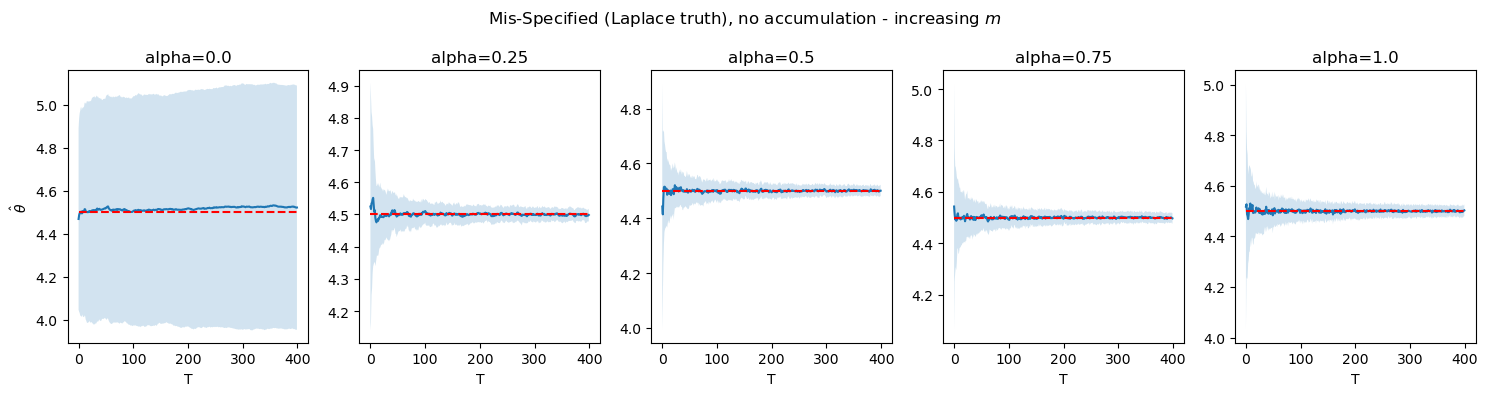

In [28]:
# Theta_hat -> (alpha=3, rep=500, T=1000)

Theta_mean = Theta_hat.mean(axis=1)
Theta_sd = Theta_hat.std(axis=1)

fig, ax = plt.subplots(figsize=(15, 4), ncols=5)

for i in range(len(alphas)):
    ax[i].plot(range(T), Theta_mean[i], label=alphas[i])
    ax[i].fill_between(range(T), Theta_mean[i] - Theta_sd[i], Theta_mean[i]+Theta_sd[i], alpha=0.2)
    ax[i].hlines(y=theta0, xmin=0, xmax=T, linestyle='dashed', color='red')
    ax[i].set_title(f'alpha={alphas[i]}')
    ax[i].set_xlabel('T')
ax[0].set_ylabel('$\hat{\\theta}$')
plt.suptitle('Mis-Specified (Laplace truth), no accumulation - increasing $m$')
plt.tight_layout()
plt.savefig('plots/incr_m_fixed_alpha.pdf')
plt.show()

In [29]:
# Exp5: misspecified + no accumulation + linear n + decreasing alpha (1/t)

theta0 = 4.5
n = 40
alpha0 = 0.8
rates = [0.0, 0.33, 0.5, 1.0, 2.0] # -> (1/t)^rate
rep = 100
T = 400

Theta_hat = np.zeros((len(rates), rep, T))
np.random.seed(10)

for i, rate in enumerate(rates):
    for j in tqdm(range(rep)):
        X = laplace.rvs(loc=theta0, scale=2., size=n) # true model
        mu_hat = estimate(X)
        Theta_hat[i,j,0] = mu_hat
        
        for t in range(T-1):
            alpha = alpha0 * (1/(t+1))**rate
            X = generate_mixture(alpha, (theta0, 2.0), mu_hat, n*(t+2)) # mix true model + working model
            mu_hat = estimate(X)
            Theta_hat[i,j,t+1] = mu_hat

100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


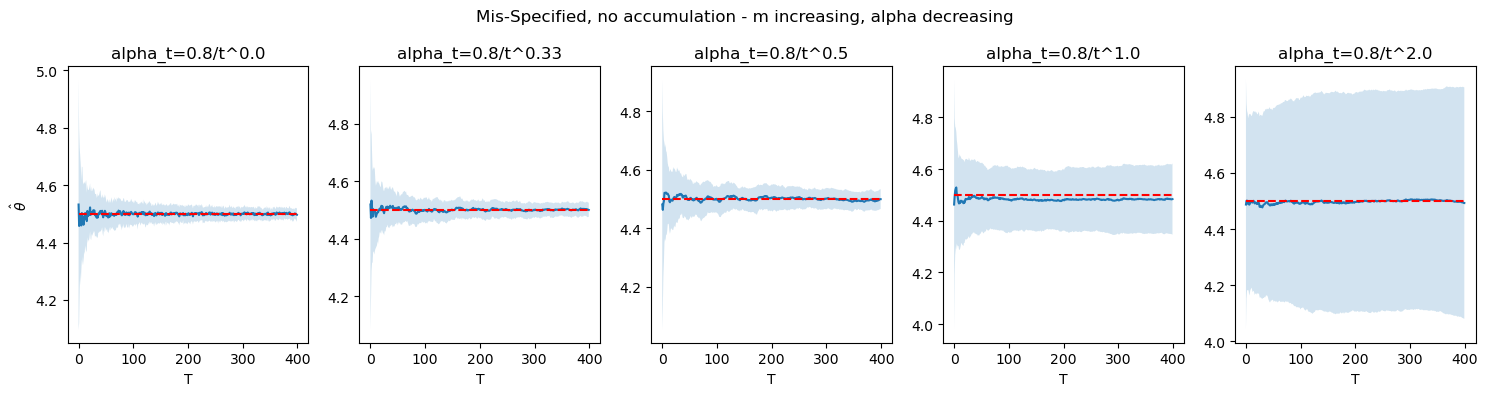

In [30]:
# Theta_hat -> (alpha=3, rep=500, T=1000)

Theta_mean = Theta_hat.mean(axis=1)
Theta_sd = Theta_hat.std(axis=1)

fig, ax = plt.subplots(figsize=(15, 4), ncols=5)

for i in range(len(alphas)):
    ax[i].plot(range(T), Theta_mean[i], label=alphas[i])
    ax[i].fill_between(range(T), Theta_mean[i] - Theta_sd[i], Theta_mean[i]+Theta_sd[i], alpha=0.2)
    ax[i].hlines(y=theta0, xmin=0, xmax=T, linestyle='dashed', color='red')
    ax[i].set_title(f'alpha_t={alpha0}/t^{rates[i]}')
    ax[i].set_xlabel('T')
ax[0].set_ylabel('$\hat{\\theta}$')
plt.suptitle(f'Mis-Specified, no accumulation - m increasing, alpha decreasing')
plt.tight_layout()
plt.savefig('plots/incr_m_decr_alpha.pdf')
plt.show()

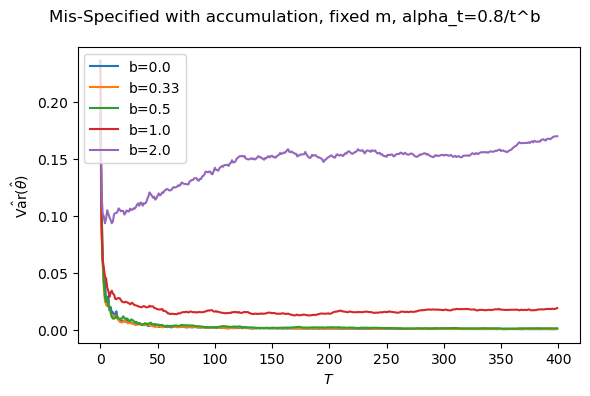

In [45]:
Theta_var = Theta_hat.var(axis=1)

fig, ax = plt.subplots(figsize=(6, 4))

for i in range(len(alphas)):
    ax.plot(range(T), Theta_var[i], label=f'b={rates[i]}')
ax.set_ylabel('$\hat{\\text{Var}}(\hat{\\theta})$')
ax.set_xlabel('$T$')
plt.legend()
plt.suptitle('Mis-Specified with accumulation, fixed m, alpha_t=0.8/t^b')
plt.tight_layout()
plt.show()

Observations:

1. In experiments 1 (correctly specified) and 2 (mis-specified): $m_t = m$ fixed, $\alpha_t=\alpha$ fixed and we do not accumulate data. The plots show that when $\alpha=0$ (no true component), the variance explodes, for for any $\alpha>0$, the estimator is unbiased and asymptotic variance is finite.

2. In experiment 3 (mis-specified): similar to 1 and 2, but now we allow accumulated data. For $\alpha=0$, now the asymptotic variance is bounded, while for any $\alpha>0$, this variance goes to 0. Thus, in this regime, the estimator is actually consistent.

3. In experiment 4 (mis-specified): we do not allow accumulation. But we allow $m_t=mt$ (size of sample collected grows linearly). Intuition: between successive versions of ChatGPT, possibly some of the existing data (previously written by human), have been editted partially or wholly using latest version of GPT, while the amount of digitalized text data has definitely increased. In this regime, surprisingly, we find $\alpha=0$ variance explodes, while for $\alpha>0$, it seems to go to 0 and we again recover consistent estimator.

4. In experiment 5 (mis-specified): we do not allow accumulation. Balance between increasing $m$ (helps) and decreasing $\alpha$ (hinders). Intuition: maybe over the years, the use of ChatGPT will be growing and hence a larger proportion of collected data will be GPT generated (if the proportion of data generated by human is bounded from below, then trivially it falls into the previous category). In this case, we still keep linearly increasign $m_t=mt$, while for $\alpha_t$, we use $\alpha_t = \alpha_0/t^{\beta}$ for $\beta\in \{0, 1/3, 1/2, 1, 2\}$. We notice that probably for $\beta<1$, it is consistent, while for $\beta=2$, the variance blows up. For $\beta=1$, not quite sure, but looks like the asymptotic variance is bounded.

## Different simulation

In [17]:
theta0 = 4.5
n = 20
rep = 1000
T = 100

Theta_hat = np.zeros((rep, T))
np.random.seed(10)

for j in tqdm(range(rep)):
    X = norm.rvs(loc=theta0, scale=5., size=n) # true model
    mu_hat = estimate(X)
    Theta_hat[j,0] = mu_hat

    for t in range(T-1):
        X = norm.rvs(loc=mu_hat, scale=5., size=n) 
        mu_hat = estimate(X)
        Theta_hat[j,t+1] = mu_hat

100%|██████████| 1000/1000 [00:08<00:00, 122.51it/s]


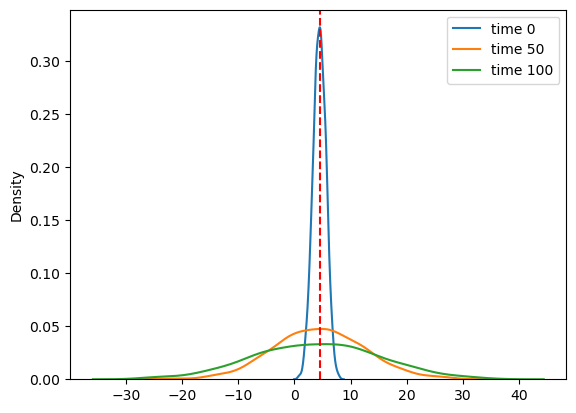

In [18]:
sns.kdeplot(Theta_hat[:,0], label='time 0')
sns.kdeplot(Theta_hat[:,T//2], label=f'time {T//2}')
sns.kdeplot(Theta_hat[:,-1], label=f'time {T}')
plt.axvline(x=theta0, color='red', linestyle='dashed')
plt.legend()
plt.show()